In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##Preparing Dataset

In [ ]:
root = '/content/drive/MyDrive/Desed_memap_files/'

In [ ]:
synth_logmel_spec = np.memmap(root + 'synthetic_logmel_spec.memap',dtype='float64',mode='r',shape=(2044,64,501))
weak_logmel_spec = np.memmap(root + 'weak_logmel_spec.memap',dtype='float64',mode='r',shape=(1336,64,501))
unlabeled_logmel_spec = np.memmap(root + 'unlabeled_logmel_spec.memap',dtype='float64',mode='r',shape=(6752,64,501))
validation_logmel_spec = np.memmap(root + 'development_logmel_spec.memap',dtype='float64',mode='r',shape=(937,64,501))
evaluation_logmel_spec = np.memmap(root + 'public_evaluation_logmel_spec.memap',dtype='float64',mode='r',shape=(692,64,501))

In [ ]:
def plotSpec(x):
    plt.imshow(x)
    plt.show()

In [ ]:
def normalization(x):
    return (x - np.mean(x, axis = 0))/np.std(x, axis = 0)


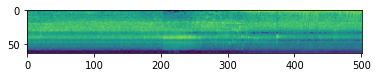

In [ ]:
plotSpec(normalization(unlabeled_logmel_spec[1500]))

In [ ]:
syn_framelevel_labels = np.memmap(root + 'syn_framewise_labels.memap',dtype='float32',mode='r',shape=(2044,10,501))
syn_cliplevel_labels = np.memmap(root + 'syn_cliplevel_labels.memap',dtype='float32',mode='r',shape=(2044,10))
weak_cliplevel_labels = np.memmap(root + 'weak_cliplevel_labels.memap',dtype='float32',mode='r',shape=(1336,10))
validation_framewise_labels = np.memmap(root + 'development_framewise_labels.memap',dtype='float32',mode='r',shape=(937,10,501))
evaluation_framewise_labels = np.memmap(root + 'public_evaluation_framewise_labels.memap',dtype='float32',mode='r',shape=(692,10,501))

##Augmentations

In [ ]:
!pip install audiomentations

     |████████████████████████████████| 67 kB 3.3 MB/s 


In [ ]:
from audiomentations import SpecCompose, SpecChannelShuffle, SpecFrequencyMask

'''
In other set of experiments we've also used gain, polarity inversion, time masking etc augmentations on raw audio waveforms from same library
'''

augment = SpecCompose(
    [
        
        SpecFrequencyMask(p=0.2),
    ]
)

##Building Model

In [ ]:
class aggregrate(tf.keras.layers.Layer):
    def __init__(self, mode):
        super(aggregrate, self).__init__()
        self.dense = tf.keras.layers.Dense(1)
        self.softmax = tf.keras.layers.Softmax()
        self.mode = mode

    def call(self, inputs):
        if self.mode == "EATP":

            dense = self.dense(inputs)
            dense /= inputs.shape[1]
            a_ct = self.softmax(dense)
            y_hat = tf.math.reduce_sum(tf.keras.layers.multiply([inputs, a_ct]), axis = 1)

        elif self.mode == "CDur":
            y_hat = tf.math.reduce_sum(tf.math.square(inputs), axis = 1)/tf.math.reduce_sum(inputs, axis = 1)
            y_hat = self.softmax(y_hat)


        return y_hat


In [ ]:
class CNN_block(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(CNN_block, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(filters = filters, kernel_size = 3, padding = 'same')
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.ReLU()
        
    def call(self, inputs):
        conv = self.conv2d(inputs)
        b_n = self.bn(conv)
        acti = self.act(b_n)
        return acti

In [ ]:
class model_audio(tf.keras.Model):
    def __init__(self, pooling_sizes, rnn_size, num_classes, dropout_rate):
        super(model_audio, self).__init__()
        self.pooling_size = pooling_sizes

        self.convblock1 = CNN_block(32)
        self.convblock2 = CNN_block(128)
        self.convblock3 = CNN_block(128)
        self.convblock4 = CNN_block(128)
        self.convblock5 = CNN_block(128)

        self.avgpool1 = tf.keras.layers.AveragePooling2D(pooling_sizes[0])
        self.avgpool2 = tf.keras.layers.AveragePooling2D(pooling_sizes[1])
        self.avgpool3 = tf.keras.layers.AveragePooling2D(pooling_sizes[2])

        self.dropout = tf.keras.layers.Dropout(rate = dropout_rate)

        self.rnn1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_size, return_sequences = True))
        self.rnn2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_size, return_sequences = True))

        self.h_dense_sed = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(rnn_size * 2))

        self.dense_sed_out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_classes, activation = 'softmax'))

        self.aggregrate_EATP = aggregrate("EATP")
        self.aggregrate_CDur = aggregrate("CDur")



    
    def call(self,inputs):

        x = self.convblock1(inputs)
        x = self.avgpool1(x)

        x1 = self.convblock2(x)
        x1 = self.convblock3(x1)
        x1 = self.avgpool2(x1)

        x2 = self.convblock4(x1)
        x2 = self.convblock5(x2)
        x2 = self.avgpool3(x2)
        xc = self.dropout(x2)

        xc = tf.transpose(xc, perm=[0, 2, 1, 3])
        rnn_in = tf.reshape(xc, [-1, xc.shape[1], tf.reduce_prod(xc.shape[2:])])

        r1_x = self.rnn1(rnn_in)
        r2_x = self.rnn2(r1_x)

        rh_x = self.h_dense_sed(r2_x)                                                   
            
        
        frame_level_prob = self.dense_sed_out(rh_x)

        clip_level_prob = self.aggregrate_CDur(frame_level_prob)

        return frame_level_prob, clip_level_prob





In [ ]:
model = model_audio([(2,1), (2,1), (1,1), (2,1)], 128, 10, 0.3)

##Writing Training routine

In [ ]:
BCE_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def f1(ground_truth, predicted):
    predicted = tf.keras.backend.round(predicted) 
    
    true_positive = tf.keras.backend.sum(tf.keras.backend.cast(ground_truth*predicted, 'float'), axis=0)
    false_positive = tf.keras.backend.sum(tf.keras.backend.cast((1-ground_truth)*predicted, 'float'), axis=0)
    false_negative = tf.keras.backend.sum(tf.keras.backend.cast(ground_truth*(1-predicted), 'float'), axis=0)

    precision = true_positive / (true_positive + false_positive + tf.keras.backend.epsilon())
    recall = true_positive / (true_positive + false_negative + tf.keras.backend.epsilon())

    f1 = 2*precision*recall / (precision+recall+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.keras.backend.mean(f1)



In [ ]:
def unlabelled_consistency_loss(unlabeled_data, optimizer, batch_size, shuffle = True):
    index_list = np.arange(unlabeled_data.shape[0])
    if shuffle:
        np.random.shuffle(index_list)
    
    for step in range (int(np.floor(unlabeled_data.shape[0]/batch_size))):
        temp_index_list = index_list[step*batch_size:(step+1)*batch_size]
        unlab_batch_data = unlabeled_data[np.ix_(temp_index_list,)]

        aug_data = augment(unlab_batch_data)
        unlab_batch_data = tf.expand_dims(normalization(unlab_batch_data), -1)
        aug_data = tf.expand_dims(normalization(aug_data), -1)
        unlab_batch_data = tf.convert_to_tensor(unlab_batch_data)
        aug_data = tf.convert_to_tensor(aug_data)
        with tf.GradientTape() as tape:

            frame_orig, clip_orig = model(unlab_batch_data)
            frame_aug, clip_aug = model(aug_data)
            unlab_cons_loss_frame = BCE_loss(frame_orig, frame_aug) 
            unlab_cons_loss_clip = BCE_loss(clip_orig, clip_aug)
            unlab_cons_loss = unlab_cons_loss_frame + unlab_cons_loss_clip
        unlab_cons_grads = tape.gradient(unlab_cons_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(unlab_cons_grads, model.trainable_variables))
    return unlab_cons_loss_frame


In [ ]:
def weakly_lab_losses(weakly_lab_data, weakly_lab_clip, optimizer, batch_size, shuffle = True):
    index_list = np.arange(weakly_lab_data.shape[0])
    if shuffle:
        np.random.shuffle(index_list)

    for step in range (int(np.floor(weakly_lab_data.shape[0]/batch_size))):
        temp_index_list = index_list[step*batch_size:(step+1)*batch_size]
        
        weakly_lab_batch_data = weakly_lab_data[np.ix_(temp_index_list,)]
        weakly_lab_clip_batch = weakly_lab_clip[np.ix_(temp_index_list,)]

        aug_data = augment(weakly_lab_batch_data)
        weakly_lab_batch_data = tf.expand_dims(normalization(weakly_lab_batch_data), -1)
        aug_data = tf.expand_dims(normalization(aug_data), -1)
        weakly_lab_batch_data = tf.convert_to_tensor(weakly_lab_batch_data)
        aug_data = tf.convert_to_tensor(aug_data)
        weakly_lab_clip_batch = tf.convert_to_tensor(weakly_lab_clip_batch)
        with tf.GradientTape() as tape:

            frame_orig, clip_orig = model(weakly_lab_batch_data)
            frame_aug, clip_aug = model(aug_data)

            weakly_lab_sup_loss = BCE_loss(clip_orig, weakly_lab_clip_batch)
            weakly_lab_cons_frame = BCE_loss(frame_orig, frame_aug)
            weakly_lab_cons_clip = BCE_loss(clip_orig, clip_aug)

            weakly_lab_total_loss = weakly_lab_sup_loss + weakly_lab_cons_frame + weakly_lab_cons_clip

        weakly_lab_grads = tape.gradient( weakly_lab_total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(weakly_lab_grads, model.trainable_variables))

    return weakly_lab_total_loss

In [ ]:
def synth_sup_loss(synth_data, synth_frame_label, synth_clip_label, optimizer, batch_size, shuffle = True):
    index_list = np.arange(synth_data.shape[0])
    if shuffle:
        np.random.shuffle(index_list)

    for step in range (int(np.floor(synth_data.shape[0]/batch_size))):
        temp_index_list = index_list[step*batch_size:(step+1)*batch_size]
        synth_batch_data = synth_data[np.ix_(temp_index_list,)]
        synth_clip_batch = synth_clip_label[np.ix_(temp_index_list,)]
        synth_frame_batch = synth_frame_label[np.ix_(temp_index_list,)]
        synth_frame_batch = tf.transpose(synth_frame_batch, perm = [0, 2, 1])
        synth_batch_data = tf.expand_dims(normalization(synth_batch_data), -1)
        synth_batch_data = tf.convert_to_tensor(synth_batch_data)
        synth_frame_batch = tf.convert_to_tensor(synth_frame_batch)
        synth_clip_batch = tf.convert_to_tensor(synth_clip_batch)
        

        with tf.GradientTape() as tape:

            frame_synth, clip_synth = model(synth_batch_data)
            synth_sup_loss_frame = BCE_loss(synth_frame_batch, frame_synth)
            synth_sup_loss_clip = BCE_loss(synth_clip_batch, clip_synth)
            synth_tot_loss = synth_sup_loss_frame + synth_sup_loss_clip

        synth_grads = tape.gradient( synth_tot_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(synth_grads, model.trainable_variables))
        


    return synth_tot_loss

In [ ]:
epochs = 10
batch_size = 32

In [ ]:
mean = tf.keras.metrics.Mean()

In [ ]:
class custom_LR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr):
        super(custom_LR, self).__init__()
        self.initial_lr = initial_lr
    def __call__(self, step):
        if (step%5) == 0:
            self.initial_lr *= 0.95
        return self.initial_lr

In [ ]:
learning_rate = custom_LR(0.0025)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
for epoch in range(epochs):
    syn_sup_loss = synth_sup_loss(synth_logmel_spec, syn_framelevel_labels, syn_cliplevel_labels, optimizer, batch_size)
    total_loss = syn_sup_loss
    
    if epoch > 5:

        weakly_lab_total_loss = weakly_lab_losses(weak_logmel_spec, weak_cliplevel_labels, optimizer, batch_size)
        unlab_consistency_loss = unlabelled_consistency_loss(unlabeled_logmel_spec, optimizer, batch_size)

        total_loss = syn_sup_loss + weakly_lab_total_loss + unlab_consistency_loss
    
    mean.update_state(total_loss)

    
    print('"Epoch : {}, loss: {}'.format(epoch + 1, mean.result().numpy()))

    mean.reset_state()


"Epoch : 1, loss: 0.594713032245636
"Epoch : 2, loss: 0.6047682762145996
"Epoch : 3, loss: 0.5226631164550781
"Epoch : 4, loss: 0.5340404510498047
"Epoch : 5, loss: 0.4948959946632385
"Epoch : 6, loss: 0.558469295501709
"Epoch : 7, loss: 4.452962398529053
"Epoch : 8, loss: 4.682732582092285
"Epoch : 9, loss: 4.627552509307861
"Epoch : 10, loss: 4.708133220672607


##Prediction and Evaluation

In [ ]:
y_pred = model.predict(tf.expand_dims(normalization(evaluation_logmel_spec), -1))

In [ ]:
np.save('/content/drive/MyDrive/SED_UDA_metadata/softmax_pred_audiomentation_BCE_50_epochs', y_pred[0])

In [ ]:
syn_csv = pd.read_csv("/content/drive/MyDrive/Audio/meta.csv", sep='\t')

In [ ]:
integer_labeling = {key:value for (key, value) in enumerate(sorted(syn_csv.event_label.unique()))}

In [ ]:
one_hot_encoded_labels = tf.keras.utils.to_categorical([i for i in integer_labeling.keys()],num_classes=len(integer_labeling)) 

In [ ]:
def one_hot_of_pred(pred):
    one_hot_pred = pred
    for aud in range(pred.shape[0]):
        for frame in range(pred.shape[1]):
            one_hot = one_hot_encoded_labels[np.argmax(pred[aud, frame, :])]
            one_hot_pred[aud, frame] = one_hot
    return one_hot_pred

In [ ]:
pred = y_pred[0]

In [ ]:
y_true = tf.transpose(evaluation_framewise_labels, [0, 2, 1])

In [ ]:
y_pred_one_hot = one_hot_of_pred(pred)

In [ ]:
f1(y_true, y_pred_one_hot)

<tf.Tensor: shape=(), dtype=float32, numpy=0.39242005>

In [ ]:
def conv_to_time(f,H = 501):
    t = (f/H)*10
    return t

In [ ]:
def final(pred):
  pred2 = np.random.random((692,501))

  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      pred2[i][j] = np.argmax(pred[i][j])
  
  pred2 = pred2.astype("int32")
  
  df = pd.DataFrame({'row1':pred2.reshape(-1, )})
  df['row2'] = df['row1'].shift(1)

  df['row2'][0] = df['row1'][0] 

  dicti = {}

  dicti['files'] = []
  dicti['onset'] = []
  dicti['offset'] = []
  dicti['activity'] = []

  start = 0

  file_no_prev = 0

  for i in range(df.shape[0]):
    file_no_current = i//501

    if(file_no_current != file_no_prev):

      end = 501
      dicti['files'].append(file_no_prev)
      dicti['activity'].append(integer_labeling[df['row1'][i]])
      dicti['onset'].append(conv_to_time(start))
      dicti['offset'].append(conv_to_time(end))
      start = 0

      file_no_prev = i//501
      continue


    if(df['row1'][i]!=df['row2'][i]):
      end = i % 501
      
      dicti['files'].append(file_no_current)
      dicti['activity'].append(integer_labeling[df['row1'][i]])
      dicti['onset'].append(conv_to_time(start))
      dicti['offset'].append(conv_to_time(end))
      start = end 

    file_no_prev = i//501

  df_predicted = pd.DataFrame.from_dict(dicti)
  return df_predicted

In [ ]:
df_pred2 = final(pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
df_pred2 = df_pred2.drop(['files'], axis = 1)

In [ ]:
df_pred2.to_csv(r'/content/drive/MyDrive/SED_UDA_metadata/synth+UDA@5_10_epoch.txt', header=None, index=None, sep=',', mode='a')

In [ ]:
df_true = final(y_true.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
df_true = df_true.drop(['files'], axis = 1)

In [ ]:
df_true.to_csv(r'/content/drive/MyDrive/SED_UDA_metadata/eval_ground_truth.txt', header=None, index=None, sep=',', mode='a')

In [ ]:
! pip install sed_eval

     |████████████████████████████████| 2.1 MB 12.9 MB/s 
  Created wheel for sed-eval: filename=sed_eval-0.2.1-py3-none-any.whl size=26124 sha256=9e7f75af13116742df172f94f00e2a5e2e4c5207475c378a4402b7073e43d142
  Stored in directory: /root/.cache/pip/wheels/96/19/00/a3ec89acfdbd2568185a1ae3020590e76ee73a47ac4ff83e84
  Created wheel for dcase-util: filename=dcase_util-0.2.19-py3-none-any.whl size=2162500 sha256=61a5e7e9f22ad497ea5657ff38b566040461733733a6a523cdba5602961c8dcb
  Stored in directory: /root/.cache/pip/wheels/38/a9/49/3dcce0c0b112670480e105a4a8e985e2ccddb7b77065b4aac2
Successfully built sed-eval dcase-util


In [ ]:
import sed_eval
import dcase_util

In [ ]:
# Usage example when reading event lists from disk
import sed_eval
import dcase_util

file_list = [
    {
     'reference_file': '/content/drive/MyDrive/SED_UDA_metadata/eval_ground_truth.txt',
     'estimated_file': '/content/drive/MyDrive/SED_UDA_metadata/synth+UDA@5_10_epoch.txt'}
    # },
    # {
    #  'reference_file': 'office_snr0_med_v2.txt',
    #  'estimated_file': 'office_snr0_med_v2_detected.txt'
    # }
]

data = []

# Get used event labels
all_data = dcase_util.containers.MetaDataContainer()
for file_pair in file_list:
    reference_event_list = sed_eval.io.load_event_list(
        filename=file_pair['reference_file']
    )
    estimated_event_list = sed_eval.io.load_event_list(
        filename=file_pair['estimated_file']
    )

    data.append({'reference_event_list': reference_event_list,
                 'estimated_event_list': estimated_event_list})

    all_data += reference_event_list

event_labels = all_data.unique_event_labels

# Start evaluating

# Create metrics classes, define parameters
segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=event_labels,
    time_resolution=1.0
)

event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
    event_label_list=event_labels,
    t_collar=0.250
)

# Go through files
for file_pair in data:
    segment_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )

    event_based_metrics.evaluate(
        reference_event_list=file_pair['reference_event_list'],
        estimated_event_list=file_pair['estimated_event_list']
    )

# Get only certain metrics
overall_segment_based_metrics = segment_based_metrics.results_overall_metrics()
print("Accuracy:", overall_segment_based_metrics['accuracy']['accuracy'])

# Or print all metrics as reports
print(segment_based_metrics)
print(event_based_metrics)

Accuracy: 1.0
Segment based metrics
  Evaluated length                  : 10.00 sec
  Evaluated files                   : 1 
  Segment length                    : 1.00 sec

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 100.00 %
    Precision                       : 100.00 %
    Recall                          : 100.00 %
  Error rate
    Error rate (ER)                 : 0.00 
    Substitution rate               : 0.00 
    Deletion rate                   : 0.00 
    Insertion rate                  : 0.00 
  Accuracy
    Sensitivity                     : 100.00 %
    Specificity                     : 0.00 %
    Balanced accuracy               : 50.00 %
    Accuracy                        : 100.00 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 100.00 %
    Precision                       : 100.00 %
    Recall                          : 100.00 %
  Error rate
    Error rate (ER)                 : 0.00 